In [1]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%time df = pd.read_csv(r'../input/dataset-for-timeseries/XTX_data.csv')
print(df.shape)
df.head()

CPU times: user 22.6 s, sys: 3.13 s, total: 25.8 s
Wall time: 38.5 s
(2999999, 61)


,askRate0,askRate1,askRate2,askRate3,askRate4,askRate5,askRate6,askRate7,askRate8,askRate9,...,bidSize6,bidSize7,bidSize8,bidSize9,bidSize10,bidSize11,bidSize12,bidSize13,bidSize14,y
0,1619.5,1620.0,1621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
1,1619.5,1620.0,1621.0,1621.5,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
2,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
3,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5
4,1619.5,1620.0,1621.0,1621.5,1622.0,NaN,NaN,NaN,NaN,NaN,...,20.0,27.0,11.0,14.0,35.0,10.0,1.0,10.0,13.0,-0.5


### 1. Pre-processing

In [2]:
x_na = np.nan   ## the NaN values is stored as an nan in numpy.
%time df_non_na = df.fillna(0)

## cumulative sum
df_non_na['y'] = df_non_na[['y']].cumsum()

## droping duplicated
%time df_nd = df_non_na.drop_duplicates()

(2999999, 61)
CPU times: user 708 ms, sys: 469 ms, total: 1.18 s
Wall time: 1.18 s
CPU times: user 5.83 s, sys: 1.52 s, total: 7.35 s
Wall time: 7.38 s


#### Train_test_split

In [3]:
def train_test_split(df, p_train = 0.667):
    N = len(df)
    y = df.y
    train_size = int(p_train*N)
    X_train = df.iloc[: train_size, :-1]
    y_train = y[: train_size]
    X_test = df.iloc[train_size :, :-1]
    y_test = y[train_size :]
    
    return X_train, y_train, X_test, y_test

%time X_train, y_train, X_test, y_test = train_test_split(df_nd, 0.7)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

CPU times: user 1.68 ms, sys: 1.12 ms, total: 2.8 ms
Wall time: 1.93 ms


((2049490, 60), (878353, 60), (2049490,), (878353,))

In [4]:
def normalized(data):
    data -= data.mean(axis = 0)
    data /= data.std(axis = 0)
    return data
%time scale_df = normalized(df_nd)
%time x_train_norm = normalized(X_train.copy())
%time y_train_norm = normalized(y_train.copy().ravel())
%time x_test_norm = normalized(X_test.copy())
%time y_test_norm = normalized(y_test.copy().ravel())

CPU times: user 2.07 s, sys: 1.88 s, total: 3.95 s
Wall time: 1.77 s
CPU times: user 1.68 s, sys: 1.36 s, total: 3.05 s
Wall time: 1.65 s
CPU times: user 17.2 ms, sys: 1.02 ms, total: 18.2 ms
Wall time: 17.4 ms
CPU times: user 753 ms, sys: 360 µs, total: 753 ms
Wall time: 474 ms
CPU times: user 9.73 ms, sys: 784 µs, total: 10.5 ms
Wall time: 10.1 ms


In [5]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

## Initialize Regressor with n_est = 10000 and max_depth = 6; early_stoping_rounds = 50.
reg = xgb.XGBRegressor(n_estimators = 10000)

## Train-Fit the model
%time reg.fit(x_train_norm, y_train_norm, eval_set=[(x_train_norm, y_train_norm), (x_test_norm, y_test_norm)],early_stopping_rounds = 50, verbose = 0)

CPU times: user 15min 59s, sys: 6.4 s, total: 16min 6s
Wall time: 4min 18s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

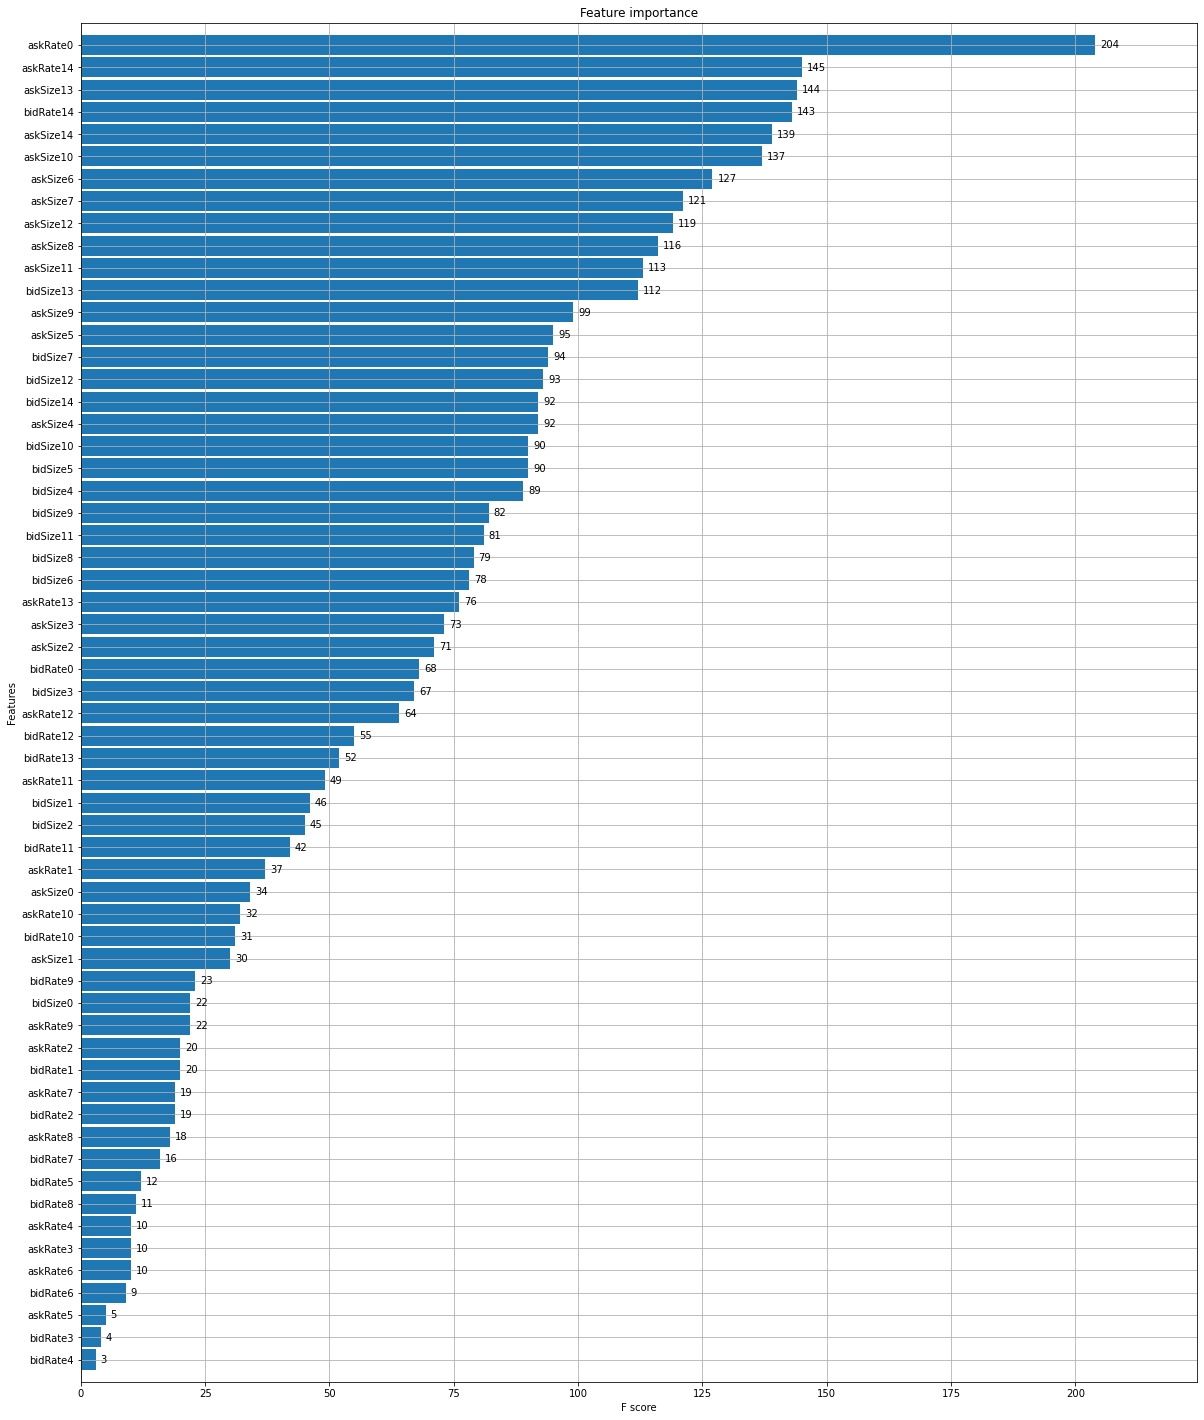

In [6]:
fig, ax = plt.subplots(1,1, figsize = (20, 25))
plot_importance(reg, height = 0.9, ax = ax);

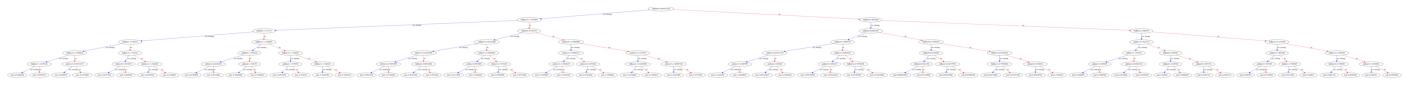

In [7]:
fig, ax = plt.subplots(1,1, figsize = (25, 10))
plot_tree(reg, num_trees = 1, ax = ax);

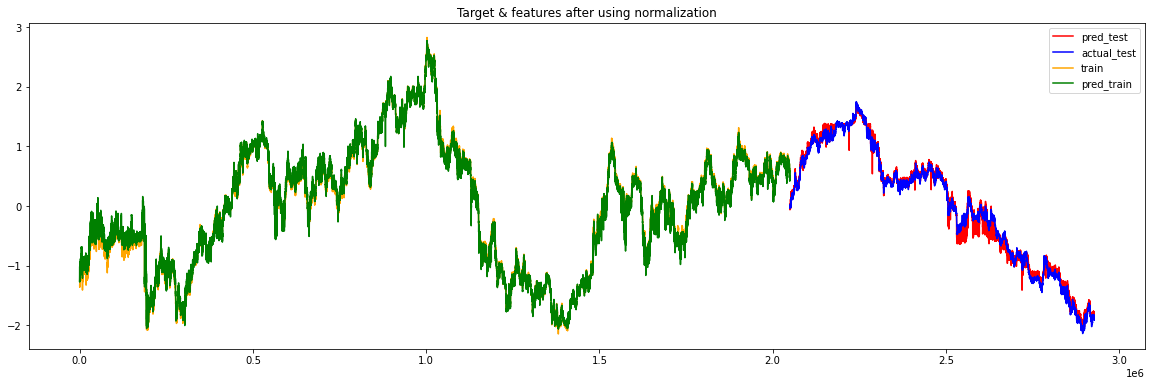

In [8]:
pred_test = reg.predict(x_test_norm)
pred_train = reg.predict(x_train_norm)

def visual_whole_data(train, test, pred_train, pred_test, tit = None):

    plt.figure(figsize = (20, 6))
    
    plt.plot(range(len(train), len(train) + len(test)), pred_test, 'red', label = 'pred_test')    
    plt.plot(range(len(train), len(train) + len(test)), test, 'blue', label = 'actual_test')
    plt.plot(range(len(train)), train, 'orange', label = 'train')
    plt.plot(range(len(train)), pred_train, 'green', label = 'pred_train')    
 
    plt.legend(loc = 'best')
    plt.title(tit)
    plt.show()

visual_whole_data(y_train_norm, y_test_norm, pred_train, pred_test, 'Target & features after using normalization')

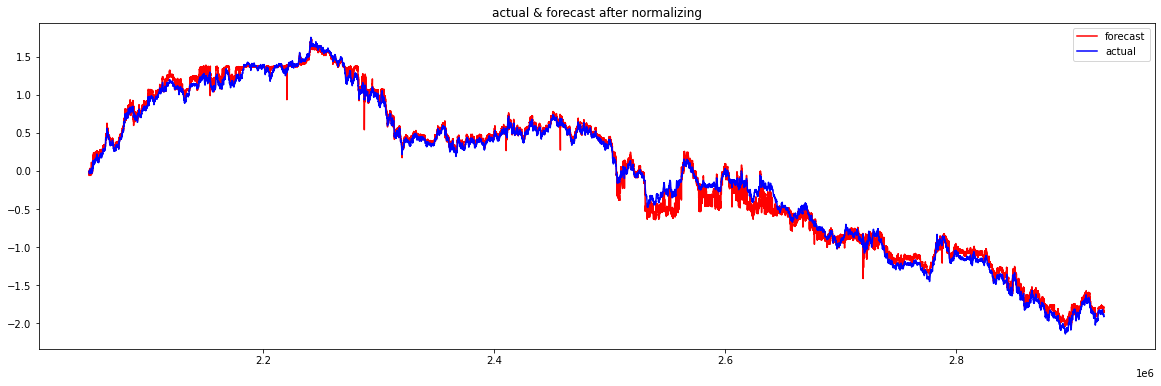

In [9]:
def visual_test_pred_only(train, pred, test, tit = None):
    plt.figure(figsize = (20, 6))
    start = len(train)
    end = len(train) + len(test)
    plt.plot(range(start, end), pred, 'red', label = 'forecast')
    plt.plot(range(start, end), test, 'blue', label = 'actual')
    plt.title(tit)
    plt.legend(loc = 'best')
    plt.show()
    
visual_test_pred_only(y_train_norm, pred_test, y_test_norm, 'actual & forecast after normalizing')

In [10]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy_2(forecast, actual):
        
    # Mean Error (ME)
    me = np.mean(forecast - actual)  
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(forecast - actual))
        
    # Root Mean Squared Error (RMSE)
    rmse = np.mean((forecast - actual)**2)**.5
    
    # correlation
    corr = np.corrcoef(forecast, actual)[0,1]  
        
    # Lag 1 Autocorrelation of Error (ACF1) 
    acf1 = acf(forecast - actual, fft = False)[1] 
    
    return({'me':me, 'mae': mae, 
            'rmse':rmse, 'acf1':acf1, 
            'corr':corr})

%time forecast_accuracy_2(pred_train, y_train_norm)

CPU times: user 34min 3s, sys: 2.8 s, total: 34min 6s
Wall time: 17min 4s


{'me': 0.003391787765536198,
 'mae': 0.04956284869220007,
 'rmse': 0.06728286687162337,
 'acf1': 0.9899910390487897,
 'corr': 0.9951009827901208}

In [11]:
%time forecast_accuracy_2(pred_test, y_test_norm)

CPU times: user 5min 46s, sys: 214 ms, total: 5min 46s
Wall time: 2min 53s


{'me': 0.014192446070044006,
 'mae': 0.06198088468948596,
 'rmse': 0.0785754454534028,
 'acf1': 0.9953662721119589,
 'corr': 0.9943151876082044}

### Grid-search CV

In [12]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor()
params = {'n_estimators': [1000, 12000], 
          'max_depth': [5, 7],
          'learning_rate': [0.3, 0.1],
          'min_child_weight': [1, 3]
         }
clf = GridSearchCV(xgb_model, params)

In [13]:
%time clf.fit(x_train_norm, y_train_norm, eval_set=[(x_train_norm, y_train_norm), (x_test_norm, y_test_norm)], early_stopping_rounds = 30, verbose = 2)

[0]	validation_0-rmse:0.80169	validation_1-rmse:0.79546
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-rmse:0.43022	validation_1-rmse:0.41279
[4]	validation_0-rmse:0.25793	validation_1-rmse:0.22638
[6]	validation_0-rmse:0.18398	validation_1-rmse:0.13721
[8]	validation_0-rmse:0.15458	validation_1-rmse:0.09693
[10]	validation_0-rmse:0.14335	validation_1-rmse:0.07920
[12]	validation_0-rmse:0.13827	validation_1-rmse:0.07164
[14]	validation_0-rmse:0.13596	validation_1-rmse:0.06856
[16]	validation_0-rmse:0.13470	validation_1-rmse:0.06693
[18]	validation_0-rmse:0.13396	validation_1-rmse:0.06573
[20]	validation_0-rmse:0.13358	validation_1-rmse:0.06526
[22]	validation_0-rmse:0.13336	validation_1-rmse:0.06445
[24]	validation_0-rmse:0.13314	validation_1-rmse:0.06440
[26]	validation_0-rmse:0.13309	validation_1-rmse:0.06385
[28]	validation_0-rmse:0.13300	validation_1-rmse

[36]	validation_0-rmse:0.07915	validation_1-rmse:0.10064
[38]	validation_0-rmse:0.07874	validation_1-rmse:0.10015
[40]	validation_0-rmse:0.07836	validation_1-rmse:0.10027
Stopping. Best iteration:
[11]	validation_0-rmse:0.08892	validation_1-rmse:0.09456

[0]	validation_0-rmse:0.80169	validation_1-rmse:0.79546
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-rmse:0.43022	validation_1-rmse:0.41279
[4]	validation_0-rmse:0.25793	validation_1-rmse:0.22638
[6]	validation_0-rmse:0.18398	validation_1-rmse:0.13721
[8]	validation_0-rmse:0.15458	validation_1-rmse:0.09693
[10]	validation_0-rmse:0.14335	validation_1-rmse:0.07920
[12]	validation_0-rmse:0.13827	validation_1-rmse:0.07164
[14]	validation_0-rmse:0.13596	validation_1-rmse:0.06856
[16]	validation_0-rmse:0.13470	validation_1-rmse:0.06693
[18]	validation_0-rmse:0.13396	validation_1-rmse:0.06573
[20]	validation_0-rms

[26]	validation_0-rmse:0.08172	validation_1-rmse:0.10081
[28]	validation_0-rmse:0.08136	validation_1-rmse:0.10098
[30]	validation_0-rmse:0.08091	validation_1-rmse:0.10097
[32]	validation_0-rmse:0.08009	validation_1-rmse:0.10098
[34]	validation_0-rmse:0.07952	validation_1-rmse:0.10054
[36]	validation_0-rmse:0.07915	validation_1-rmse:0.10064
[38]	validation_0-rmse:0.07874	validation_1-rmse:0.10015
[40]	validation_0-rmse:0.07836	validation_1-rmse:0.10027
Stopping. Best iteration:
[11]	validation_0-rmse:0.08892	validation_1-rmse:0.09456

[0]	validation_0-rmse:0.80169	validation_1-rmse:0.79546
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-rmse:0.43022	validation_1-rmse:0.41279
[4]	validation_0-rmse:0.25793	validation_1-rmse:0.22638
[6]	validation_0-rmse:0.18398	validation_1-rmse:0.13721
[8]	validation_0-rmse:0.15458	validation_1-rmse:0.09693
[10]	validation_0-rms

[16]	validation_0-rmse:0.08537	validation_1-rmse:0.09718
[18]	validation_0-rmse:0.08484	validation_1-rmse:0.09737
[20]	validation_0-rmse:0.08366	validation_1-rmse:0.09878
[22]	validation_0-rmse:0.08283	validation_1-rmse:0.09932
[24]	validation_0-rmse:0.08228	validation_1-rmse:0.09997
[26]	validation_0-rmse:0.08172	validation_1-rmse:0.10081
[28]	validation_0-rmse:0.08136	validation_1-rmse:0.10098
[30]	validation_0-rmse:0.08091	validation_1-rmse:0.10097
[32]	validation_0-rmse:0.08010	validation_1-rmse:0.10098
[34]	validation_0-rmse:0.07952	validation_1-rmse:0.10054
[36]	validation_0-rmse:0.07915	validation_1-rmse:0.10064
[38]	validation_0-rmse:0.07874	validation_1-rmse:0.10015
[40]	validation_0-rmse:0.07836	validation_1-rmse:0.10027
Stopping. Best iteration:
[11]	validation_0-rmse:0.08892	validation_1-rmse:0.09456

[0]	validation_0-rmse:0.80169	validation_1-rmse:0.79546
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validati

[6]	validation_0-rmse:0.12644	validation_1-rmse:0.12111
[8]	validation_0-rmse:0.09918	validation_1-rmse:0.09950
[10]	validation_0-rmse:0.09085	validation_1-rmse:0.09523
[12]	validation_0-rmse:0.08764	validation_1-rmse:0.09474
[14]	validation_0-rmse:0.08651	validation_1-rmse:0.09592
[16]	validation_0-rmse:0.08537	validation_1-rmse:0.09718
[18]	validation_0-rmse:0.08484	validation_1-rmse:0.09737
[20]	validation_0-rmse:0.08366	validation_1-rmse:0.09878
[22]	validation_0-rmse:0.08283	validation_1-rmse:0.09932
[24]	validation_0-rmse:0.08228	validation_1-rmse:0.09997
[26]	validation_0-rmse:0.08172	validation_1-rmse:0.10081
[28]	validation_0-rmse:0.08136	validation_1-rmse:0.10098
[30]	validation_0-rmse:0.08091	validation_1-rmse:0.10097
[32]	validation_0-rmse:0.08010	validation_1-rmse:0.10098
[34]	validation_0-rmse:0.07952	validation_1-rmse:0.10054
[36]	validation_0-rmse:0.07915	validation_1-rmse:0.10064
[38]	validation_0-rmse:0.07874	validation_1-rmse:0.10015
[40]	validation_0-rmse:0.07836	va

[16]	validation_0-rmse:0.06714	validation_1-rmse:0.08243
[18]	validation_0-rmse:0.06671	validation_1-rmse:0.08305
[20]	validation_0-rmse:0.06619	validation_1-rmse:0.08360
[22]	validation_0-rmse:0.06531	validation_1-rmse:0.08350
[24]	validation_0-rmse:0.06459	validation_1-rmse:0.08385
[26]	validation_0-rmse:0.06401	validation_1-rmse:0.08418
[28]	validation_0-rmse:0.06377	validation_1-rmse:0.08413
[30]	validation_0-rmse:0.06301	validation_1-rmse:0.08420
[32]	validation_0-rmse:0.06258	validation_1-rmse:0.08407
[34]	validation_0-rmse:0.06231	validation_1-rmse:0.08411
[36]	validation_0-rmse:0.06198	validation_1-rmse:0.08407
[38]	validation_0-rmse:0.06173	validation_1-rmse:0.08413
[40]	validation_0-rmse:0.06167	validation_1-rmse:0.08414
Stopping. Best iteration:
[11]	validation_0-rmse:0.06798	validation_1-rmse:0.08055

[0]	validation_0-rmse:0.78299	validation_1-rmse:0.77997
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validati

[28]	validation_0-rmse:0.16862	validation_1-rmse:0.08961
[30]	validation_0-rmse:0.16830	validation_1-rmse:0.08948
[32]	validation_0-rmse:0.16808	validation_1-rmse:0.08962
[34]	validation_0-rmse:0.16791	validation_1-rmse:0.08983
[36]	validation_0-rmse:0.16763	validation_1-rmse:0.08961
[38]	validation_0-rmse:0.16714	validation_1-rmse:0.08950
[40]	validation_0-rmse:0.16699	validation_1-rmse:0.08955
[42]	validation_0-rmse:0.16689	validation_1-rmse:0.08944
Stopping. Best iteration:
[12]	validation_0-rmse:0.17269	validation_1-rmse:0.08784

[0]	validation_0-rmse:0.77819	validation_1-rmse:0.77472
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-rmse:0.37644	validation_1-rmse:0.37211
[4]	validation_0-rmse:0.18502	validation_1-rmse:0.18207
[6]	validation_0-rmse:0.10201	validation_1-rmse:0.10487
[8]	validation_0-rmse:0.07437	validation_1-rmse:0.08303
[10]	validation_0-rms

[28]	validation_0-rmse:0.16862	validation_1-rmse:0.08961
[30]	validation_0-rmse:0.16829	validation_1-rmse:0.08949
[32]	validation_0-rmse:0.16808	validation_1-rmse:0.08962
[34]	validation_0-rmse:0.16791	validation_1-rmse:0.08983
[36]	validation_0-rmse:0.16763	validation_1-rmse:0.08961
[38]	validation_0-rmse:0.16714	validation_1-rmse:0.08950
[40]	validation_0-rmse:0.16698	validation_1-rmse:0.08955
[42]	validation_0-rmse:0.16688	validation_1-rmse:0.08945
Stopping. Best iteration:
[12]	validation_0-rmse:0.17269	validation_1-rmse:0.08785

[0]	validation_0-rmse:0.77819	validation_1-rmse:0.77472
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-rmse:0.37644	validation_1-rmse:0.37211
[4]	validation_0-rmse:0.18502	validation_1-rmse:0.18207
[6]	validation_0-rmse:0.10201	validation_1-rmse:0.10488
[8]	validation_0-rmse:0.07437	validation_1-rmse:0.08303
[10]	validation_0-rms

[28]	validation_0-rmse:0.16862	validation_1-rmse:0.08961
[30]	validation_0-rmse:0.16829	validation_1-rmse:0.08949
[32]	validation_0-rmse:0.16808	validation_1-rmse:0.08962
[34]	validation_0-rmse:0.16791	validation_1-rmse:0.08983
[36]	validation_0-rmse:0.16763	validation_1-rmse:0.08961
[38]	validation_0-rmse:0.16714	validation_1-rmse:0.08950
[40]	validation_0-rmse:0.16698	validation_1-rmse:0.08955
[42]	validation_0-rmse:0.16688	validation_1-rmse:0.08945
Stopping. Best iteration:
[12]	validation_0-rmse:0.17269	validation_1-rmse:0.08785

[0]	validation_0-rmse:0.77819	validation_1-rmse:0.77472
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-rmse:0.37644	validation_1-rmse:0.37211
[4]	validation_0-rmse:0.18502	validation_1-rmse:0.18207
[6]	validation_0-rmse:0.10201	validation_1-rmse:0.10488
[8]	validation_0-rmse:0.07437	validation_1-rmse:0.08303
[10]	validation_0-rms

[162]	validation_0-rmse:0.13217	validation_1-rmse:0.05933
[164]	validation_0-rmse:0.13215	validation_1-rmse:0.05933
[166]	validation_0-rmse:0.13213	validation_1-rmse:0.05931
[168]	validation_0-rmse:0.13210	validation_1-rmse:0.05925
[170]	validation_0-rmse:0.13207	validation_1-rmse:0.05923
[172]	validation_0-rmse:0.13207	validation_1-rmse:0.05923
[174]	validation_0-rmse:0.13204	validation_1-rmse:0.05921
[176]	validation_0-rmse:0.13201	validation_1-rmse:0.05921
[178]	validation_0-rmse:0.13199	validation_1-rmse:0.05919
[180]	validation_0-rmse:0.13197	validation_1-rmse:0.05914
[182]	validation_0-rmse:0.13196	validation_1-rmse:0.05919
[184]	validation_0-rmse:0.13195	validation_1-rmse:0.05912
[186]	validation_0-rmse:0.13195	validation_1-rmse:0.05917
[188]	validation_0-rmse:0.13194	validation_1-rmse:0.05913
[190]	validation_0-rmse:0.13195	validation_1-rmse:0.05911
[192]	validation_0-rmse:0.13199	validation_1-rmse:0.05913
[194]	validation_0-rmse:0.13196	validation_1-rmse:0.05909
[196]	validati

[28]	validation_0-rmse:0.20166	validation_1-rmse:0.10007
[30]	validation_0-rmse:0.19718	validation_1-rmse:0.09493
[32]	validation_0-rmse:0.19465	validation_1-rmse:0.09155
[34]	validation_0-rmse:0.19124	validation_1-rmse:0.08847
[36]	validation_0-rmse:0.18998	validation_1-rmse:0.08695
[38]	validation_0-rmse:0.18884	validation_1-rmse:0.08628
[40]	validation_0-rmse:0.18800	validation_1-rmse:0.08609
[42]	validation_0-rmse:0.18731	validation_1-rmse:0.08555
[44]	validation_0-rmse:0.18699	validation_1-rmse:0.08564
[46]	validation_0-rmse:0.18672	validation_1-rmse:0.08603
[48]	validation_0-rmse:0.18641	validation_1-rmse:0.08629
[50]	validation_0-rmse:0.18628	validation_1-rmse:0.08684
[52]	validation_0-rmse:0.18600	validation_1-rmse:0.08666
[54]	validation_0-rmse:0.18575	validation_1-rmse:0.08655
[56]	validation_0-rmse:0.18559	validation_1-rmse:0.08687
[58]	validation_0-rmse:0.18546	validation_1-rmse:0.08689
[60]	validation_0-rmse:0.18539	validation_1-rmse:0.08703
[62]	validation_0-rmse:0.18533	

[82]	validation_0-rmse:0.13307	validation_1-rmse:0.06149
[84]	validation_0-rmse:0.13301	validation_1-rmse:0.06142
[86]	validation_0-rmse:0.13298	validation_1-rmse:0.06142
[88]	validation_0-rmse:0.13295	validation_1-rmse:0.06134
[90]	validation_0-rmse:0.13291	validation_1-rmse:0.06116
[92]	validation_0-rmse:0.13282	validation_1-rmse:0.06102
[94]	validation_0-rmse:0.13282	validation_1-rmse:0.06096
[96]	validation_0-rmse:0.13276	validation_1-rmse:0.06086
[98]	validation_0-rmse:0.13269	validation_1-rmse:0.06066
[100]	validation_0-rmse:0.13267	validation_1-rmse:0.06051
[102]	validation_0-rmse:0.13266	validation_1-rmse:0.06053
[104]	validation_0-rmse:0.13263	validation_1-rmse:0.06041
[106]	validation_0-rmse:0.13257	validation_1-rmse:0.06035
[108]	validation_0-rmse:0.13257	validation_1-rmse:0.06032
[110]	validation_0-rmse:0.13256	validation_1-rmse:0.06031
[112]	validation_0-rmse:0.13254	validation_1-rmse:0.06028
[114]	validation_0-rmse:0.13255	validation_1-rmse:0.06026
[116]	validation_0-rmse

[36]	validation_0-rmse:0.08671	validation_1-rmse:0.09428
[38]	validation_0-rmse:0.08527	validation_1-rmse:0.09353
[40]	validation_0-rmse:0.08411	validation_1-rmse:0.09300
[42]	validation_0-rmse:0.08323	validation_1-rmse:0.09266
[44]	validation_0-rmse:0.08258	validation_1-rmse:0.09270
[46]	validation_0-rmse:0.08186	validation_1-rmse:0.09246
[48]	validation_0-rmse:0.08125	validation_1-rmse:0.09223
[50]	validation_0-rmse:0.08082	validation_1-rmse:0.09227
[52]	validation_0-rmse:0.08039	validation_1-rmse:0.09232
[54]	validation_0-rmse:0.08015	validation_1-rmse:0.09256
[56]	validation_0-rmse:0.07971	validation_1-rmse:0.09242
[58]	validation_0-rmse:0.07945	validation_1-rmse:0.09236
[60]	validation_0-rmse:0.07927	validation_1-rmse:0.09233
[62]	validation_0-rmse:0.07913	validation_1-rmse:0.09248
[64]	validation_0-rmse:0.07891	validation_1-rmse:0.09245
[66]	validation_0-rmse:0.07866	validation_1-rmse:0.09246
[68]	validation_0-rmse:0.07844	validation_1-rmse:0.09263
[70]	validation_0-rmse:0.07830	

[2]	validation_0-rmse:0.83198	validation_1-rmse:0.82619
[4]	validation_0-rmse:0.68656	validation_1-rmse:0.67697
[6]	validation_0-rmse:0.56945	validation_1-rmse:0.55581
[8]	validation_0-rmse:0.47560	validation_1-rmse:0.45751
[10]	validation_0-rmse:0.40056	validation_1-rmse:0.37836
[12]	validation_0-rmse:0.34091	validation_1-rmse:0.31433
[14]	validation_0-rmse:0.29378	validation_1-rmse:0.26288
[16]	validation_0-rmse:0.25682	validation_1-rmse:0.22128
[18]	validation_0-rmse:0.22806	validation_1-rmse:0.18805
[20]	validation_0-rmse:0.20596	validation_1-rmse:0.16131
[22]	validation_0-rmse:0.18892	validation_1-rmse:0.14019
[24]	validation_0-rmse:0.17602	validation_1-rmse:0.12341
[26]	validation_0-rmse:0.16631	validation_1-rmse:0.11023
[28]	validation_0-rmse:0.15887	validation_1-rmse:0.09986
[30]	validation_0-rmse:0.15327	validation_1-rmse:0.09174
[32]	validation_0-rmse:0.14909	validation_1-rmse:0.08525
[34]	validation_0-rmse:0.14583	validation_1-rmse:0.08036
[36]	validation_0-rmse:0.14335	vali

[288]	validation_0-rmse:0.13147	validation_1-rmse:0.05911
[290]	validation_0-rmse:0.13144	validation_1-rmse:0.05911
[292]	validation_0-rmse:0.13145	validation_1-rmse:0.05909
[294]	validation_0-rmse:0.13147	validation_1-rmse:0.05910
[296]	validation_0-rmse:0.13146	validation_1-rmse:0.05909
[298]	validation_0-rmse:0.13142	validation_1-rmse:0.05902
[300]	validation_0-rmse:0.13143	validation_1-rmse:0.05903
[302]	validation_0-rmse:0.13141	validation_1-rmse:0.05905
[304]	validation_0-rmse:0.13143	validation_1-rmse:0.05909
[306]	validation_0-rmse:0.13145	validation_1-rmse:0.05910
[308]	validation_0-rmse:0.13143	validation_1-rmse:0.05908
[310]	validation_0-rmse:0.13140	validation_1-rmse:0.05905
[312]	validation_0-rmse:0.13141	validation_1-rmse:0.05908
[314]	validation_0-rmse:0.13139	validation_1-rmse:0.05908
[316]	validation_0-rmse:0.13138	validation_1-rmse:0.05909
[318]	validation_0-rmse:0.13140	validation_1-rmse:0.05912
[320]	validation_0-rmse:0.13140	validation_1-rmse:0.05911
[322]	validati

[0]	validation_0-rmse:1.00638	validation_1-rmse:1.00546
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-rmse:0.81585	validation_1-rmse:0.81254
[4]	validation_0-rmse:0.66193	validation_1-rmse:0.65675
[6]	validation_0-rmse:0.53780	validation_1-rmse:0.53150
[8]	validation_0-rmse:0.43784	validation_1-rmse:0.43037
[10]	validation_0-rmse:0.35768	validation_1-rmse:0.34918
[12]	validation_0-rmse:0.29365	validation_1-rmse:0.28466
[14]	validation_0-rmse:0.24289	validation_1-rmse:0.23345
[16]	validation_0-rmse:0.20295	validation_1-rmse:0.19354
[18]	validation_0-rmse:0.17192	validation_1-rmse:0.16286
[20]	validation_0-rmse:0.14806	validation_1-rmse:0.14028
[22]	validation_0-rmse:0.13019	validation_1-rmse:0.12388
[24]	validation_0-rmse:0.11697	validation_1-rmse:0.11237
[26]	validation_0-rmse:0.10754	validation_1-rmse:0.10476
[28]	validation_0-rmse:0.10083	validation_1-rmse

[200]	validation_0-rmse:0.13182	validation_1-rmse:0.05926
[202]	validation_0-rmse:0.13180	validation_1-rmse:0.05920
[204]	validation_0-rmse:0.13185	validation_1-rmse:0.05924
[206]	validation_0-rmse:0.13185	validation_1-rmse:0.05920
[208]	validation_0-rmse:0.13182	validation_1-rmse:0.05918
[210]	validation_0-rmse:0.13181	validation_1-rmse:0.05921
[212]	validation_0-rmse:0.13180	validation_1-rmse:0.05923
[214]	validation_0-rmse:0.13178	validation_1-rmse:0.05923
[216]	validation_0-rmse:0.13177	validation_1-rmse:0.05923
[218]	validation_0-rmse:0.13178	validation_1-rmse:0.05926
[220]	validation_0-rmse:0.13178	validation_1-rmse:0.05927
[222]	validation_0-rmse:0.13179	validation_1-rmse:0.05927
[224]	validation_0-rmse:0.13176	validation_1-rmse:0.05921
[226]	validation_0-rmse:0.13175	validation_1-rmse:0.05921
[228]	validation_0-rmse:0.13173	validation_1-rmse:0.05921
[230]	validation_0-rmse:0.13172	validation_1-rmse:0.05919
[232]	validation_0-rmse:0.13171	validation_1-rmse:0.05915
[234]	validati

[60]	validation_0-rmse:0.18539	validation_1-rmse:0.08703
[62]	validation_0-rmse:0.18533	validation_1-rmse:0.08721
[64]	validation_0-rmse:0.18522	validation_1-rmse:0.08728
[66]	validation_0-rmse:0.18495	validation_1-rmse:0.08726
[68]	validation_0-rmse:0.18491	validation_1-rmse:0.08742
[70]	validation_0-rmse:0.18487	validation_1-rmse:0.08753
[72]	validation_0-rmse:0.18476	validation_1-rmse:0.08776
Stopping. Best iteration:
[42]	validation_0-rmse:0.18731	validation_1-rmse:0.08555

[0]	validation_0-rmse:1.00554	validation_1-rmse:1.00371
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-rmse:0.81332	validation_1-rmse:0.80923
[4]	validation_0-rmse:0.65779	validation_1-rmse:0.65180
[6]	validation_0-rmse:0.53238	validation_1-rmse:0.52532
[8]	validation_0-rmse:0.43138	validation_1-rmse:0.42309
[10]	validation_0-rmse:0.35019	validation_1-rmse:0.34095
[12]	validation_0-rms

[114]	validation_0-rmse:0.13077	validation_1-rmse:0.05946
[116]	validation_0-rmse:0.13071	validation_1-rmse:0.05940
[118]	validation_0-rmse:0.13067	validation_1-rmse:0.05936
[120]	validation_0-rmse:0.13065	validation_1-rmse:0.05934
[122]	validation_0-rmse:0.13064	validation_1-rmse:0.05935
[124]	validation_0-rmse:0.13062	validation_1-rmse:0.05926
[126]	validation_0-rmse:0.13057	validation_1-rmse:0.05922
[128]	validation_0-rmse:0.13055	validation_1-rmse:0.05920
[130]	validation_0-rmse:0.13054	validation_1-rmse:0.05922
[132]	validation_0-rmse:0.13053	validation_1-rmse:0.05922
[134]	validation_0-rmse:0.13052	validation_1-rmse:0.05920
[136]	validation_0-rmse:0.13050	validation_1-rmse:0.05921
[138]	validation_0-rmse:0.13048	validation_1-rmse:0.05916
[140]	validation_0-rmse:0.13045	validation_1-rmse:0.05917
[142]	validation_0-rmse:0.13043	validation_1-rmse:0.05917
[144]	validation_0-rmse:0.13041	validation_1-rmse:0.05916
[146]	validation_0-rmse:0.13042	validation_1-rmse:0.05914
[148]	validati

[42]	validation_0-rmse:0.06516	validation_1-rmse:0.08139
[44]	validation_0-rmse:0.06511	validation_1-rmse:0.08183
[46]	validation_0-rmse:0.06509	validation_1-rmse:0.08200
[48]	validation_0-rmse:0.06506	validation_1-rmse:0.08208
[50]	validation_0-rmse:0.06492	validation_1-rmse:0.08233
[52]	validation_0-rmse:0.06480	validation_1-rmse:0.08246
[54]	validation_0-rmse:0.06468	validation_1-rmse:0.08263
[56]	validation_0-rmse:0.06446	validation_1-rmse:0.08290
[58]	validation_0-rmse:0.06434	validation_1-rmse:0.08303
[60]	validation_0-rmse:0.06428	validation_1-rmse:0.08335
[62]	validation_0-rmse:0.06404	validation_1-rmse:0.08368
[64]	validation_0-rmse:0.06397	validation_1-rmse:0.08382
Stopping. Best iteration:
[34]	validation_0-rmse:0.06702	validation_1-rmse:0.08052

[0]	validation_0-rmse:1.00618	validation_1-rmse:1.00520
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-

[180]	validation_0-rmse:0.13010	validation_1-rmse:0.05909
[182]	validation_0-rmse:0.13012	validation_1-rmse:0.05909
[184]	validation_0-rmse:0.13012	validation_1-rmse:0.05909
Stopping. Best iteration:
[154]	validation_0-rmse:0.13037	validation_1-rmse:0.05904

[0]	validation_0-rmse:1.00672	validation_1-rmse:1.00577
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-rmse:0.81681	validation_1-rmse:0.81448
[4]	validation_0-rmse:0.66313	validation_1-rmse:0.65976
[6]	validation_0-rmse:0.53900	validation_1-rmse:0.53569
[8]	validation_0-rmse:0.43885	validation_1-rmse:0.43535
[10]	validation_0-rmse:0.35814	validation_1-rmse:0.35533
[12]	validation_0-rmse:0.29336	validation_1-rmse:0.29157
[14]	validation_0-rmse:0.24155	validation_1-rmse:0.24097
[16]	validation_0-rmse:0.20027	validation_1-rmse:0.20116
[18]	validation_0-rmse:0.16770	validation_1-rmse:0.17054
[20]	validation_0

[34]	validation_0-rmse:0.07677	validation_1-rmse:0.09773
[36]	validation_0-rmse:0.07509	validation_1-rmse:0.09766
[38]	validation_0-rmse:0.07393	validation_1-rmse:0.09825
[40]	validation_0-rmse:0.07293	validation_1-rmse:0.09835
[42]	validation_0-rmse:0.07226	validation_1-rmse:0.09803
[44]	validation_0-rmse:0.07164	validation_1-rmse:0.09771
[46]	validation_0-rmse:0.07126	validation_1-rmse:0.09814
[48]	validation_0-rmse:0.07063	validation_1-rmse:0.09810
[50]	validation_0-rmse:0.07044	validation_1-rmse:0.09823
[52]	validation_0-rmse:0.06985	validation_1-rmse:0.09821
[54]	validation_0-rmse:0.06962	validation_1-rmse:0.09806
[56]	validation_0-rmse:0.06937	validation_1-rmse:0.09802
[58]	validation_0-rmse:0.06920	validation_1-rmse:0.09849
[60]	validation_0-rmse:0.06907	validation_1-rmse:0.09849
[62]	validation_0-rmse:0.06878	validation_1-rmse:0.09868
[64]	validation_0-rmse:0.06857	validation_1-rmse:0.09855
Stopping. Best iteration:
[35]	validation_0-rmse:0.07585	validation_1-rmse:0.09763

[0]	

[58]	validation_0-rmse:0.06470	validation_1-rmse:0.09772
[60]	validation_0-rmse:0.06438	validation_1-rmse:0.09777
[62]	validation_0-rmse:0.06405	validation_1-rmse:0.09763
[64]	validation_0-rmse:0.06383	validation_1-rmse:0.09782
[66]	validation_0-rmse:0.06331	validation_1-rmse:0.09781
Stopping. Best iteration:
[37]	validation_0-rmse:0.07180	validation_1-rmse:0.09700

[0]	validation_0-rmse:1.01185	validation_1-rmse:1.00672
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-rmse:0.83166	validation_1-rmse:0.81667
[4]	validation_0-rmse:0.68681	validation_1-rmse:0.66344
[6]	validation_0-rmse:0.57117	validation_1-rmse:0.53953
[8]	validation_0-rmse:0.47872	validation_1-rmse:0.43992
[10]	validation_0-rmse:0.40566	validation_1-rmse:0.35913
[12]	validation_0-rmse:0.34838	validation_1-rmse:0.29501
[14]	validation_0-rmse:0.30382	validation_1-rmse:0.24372
[16]	validation_0-rms

[34]	validation_0-rmse:0.14380	validation_1-rmse:0.07908
[36]	validation_0-rmse:0.14123	validation_1-rmse:0.07495
[38]	validation_0-rmse:0.13926	validation_1-rmse:0.07185
[40]	validation_0-rmse:0.13775	validation_1-rmse:0.06940
[42]	validation_0-rmse:0.13653	validation_1-rmse:0.06748
[44]	validation_0-rmse:0.13559	validation_1-rmse:0.06594
[46]	validation_0-rmse:0.13484	validation_1-rmse:0.06471
[48]	validation_0-rmse:0.13424	validation_1-rmse:0.06368
[50]	validation_0-rmse:0.13376	validation_1-rmse:0.06299
[52]	validation_0-rmse:0.13331	validation_1-rmse:0.06241
[54]	validation_0-rmse:0.13296	validation_1-rmse:0.06190
[56]	validation_0-rmse:0.13264	validation_1-rmse:0.06152
[58]	validation_0-rmse:0.13242	validation_1-rmse:0.06121
[60]	validation_0-rmse:0.13222	validation_1-rmse:0.06105
[62]	validation_0-rmse:0.13202	validation_1-rmse:0.06078
[64]	validation_0-rmse:0.13187	validation_1-rmse:0.06060
[66]	validation_0-rmse:0.13176	validation_1-rmse:0.06044
[68]	validation_0-rmse:0.13167	

[56]	validation_0-rmse:0.16986	validation_1-rmse:0.08313
[58]	validation_0-rmse:0.16973	validation_1-rmse:0.08317
[60]	validation_0-rmse:0.16958	validation_1-rmse:0.08308
[62]	validation_0-rmse:0.16937	validation_1-rmse:0.08295
[64]	validation_0-rmse:0.16926	validation_1-rmse:0.08293
[66]	validation_0-rmse:0.16919	validation_1-rmse:0.08308
[68]	validation_0-rmse:0.16905	validation_1-rmse:0.08308
[70]	validation_0-rmse:0.16898	validation_1-rmse:0.08316
[72]	validation_0-rmse:0.16893	validation_1-rmse:0.08326
[74]	validation_0-rmse:0.16884	validation_1-rmse:0.08324
[76]	validation_0-rmse:0.16877	validation_1-rmse:0.08322
[78]	validation_0-rmse:0.16871	validation_1-rmse:0.08337
Stopping. Best iteration:
[48]	validation_0-rmse:0.17064	validation_1-rmse:0.08257

[0]	validation_0-rmse:1.00456	validation_1-rmse:1.00346
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[2]	validation_0-

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [14]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_learning_rate',
 'param_max_depth',
 'param_min_child_weight',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [15]:
clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 1000}

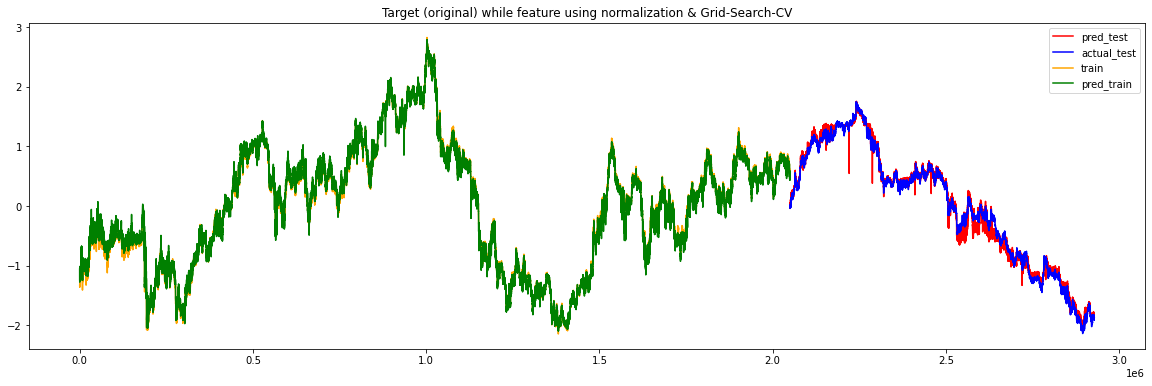

In [17]:
final_test_pred = clf.predict(x_test_norm)
final_train_pred = clf.predict(x_train_norm)

visual_whole_data(y_train_norm, y_test_norm, final_train_pred, final_test_pred,
                  'Target (original) while feature using normalization & Grid-Search-CV')

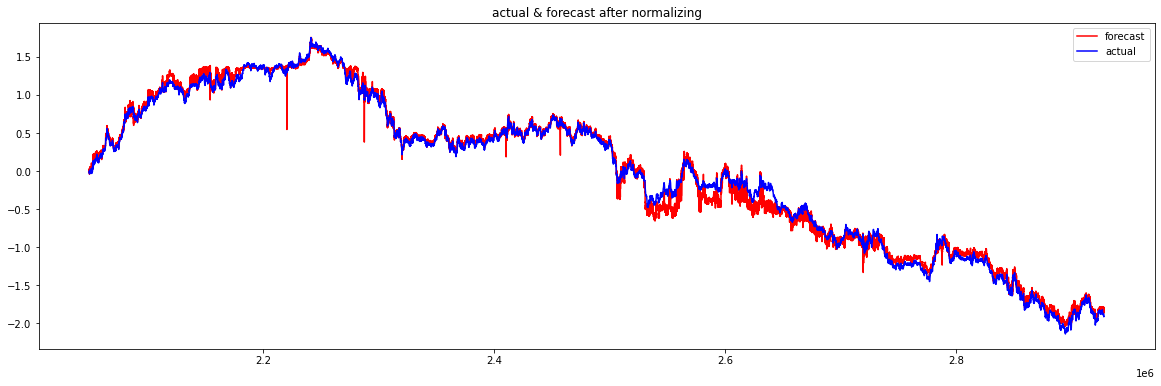

In [18]:
visual_test_pred_only(y_train_norm, final_test_pred, y_test_norm, 'actual & forecast after normalizing')

In [19]:
%time forecast_accuracy_2(final_train_pred, y_train_norm)

CPU times: user 35min 37s, sys: 4.92 s, total: 35min 42s
Wall time: 17min 54s


{'me': 0.0018791774464124542,
 'mae': 0.038664673029206086,
 'rmse': 0.052708292950541955,
 'acf1': 0.9892869500184225,
 'corr': 0.9959911590337381}

In [20]:
%time forecast_accuracy_2(final_test_pred, y_test_norm)

CPU times: user 6min 15s, sys: 507 ms, total: 6min 16s
Wall time: 3min 8s


{'me': 0.008925842896519867,
 'mae': 0.05890217355529119,
 'rmse': 0.07688155423147276,
 'acf1': 0.996431385970099,
 'corr': 0.9943948038729826}